## Non-intrusive probes

In [ ]:
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn

from probes import *
from utils import *


# MODEL_PATH = "/Model/mistralai/Mistral-7B-v0.1"
# MODEL_PATH = "/Model/mistralai/Mistral-7B-Instruct-v0.1"
# MODEL_PATH = "/Model/meta-llama/Meta-Llama-3.1-70B-Instruct-hf"
# MODEL_PATH = "/Model/meta-llama/Meta-Llama-3.1-70B-hf"
# MODEL_PATH = "/Model/meta-llama/Meta-Llama-3.1-8B-Instruct-hf"
MODEL_PATH = "/Model/meta-llama/Meta-Llama-3.1-8B-hf"
# MODEL_PATH = "/Model/meta-llama/Llama-2-13b-chat-hf"
# MODEL_PATH = "/Model/meta-llama/Llama-2-13b-hf"
# MODEL_PATH = "/Model/meta-llama/Llama-2-7b-chat-hf"

model_name = os.path.basename(MODEL_PATH)

layer_index = 12

seed = 0


In [ ]:
import joblib

probes_dir = f"probes/{model_name}/seed={seed}"
lr = joblib.load(os.path.join(probes_dir, "lr.joblib"))
mlp = joblib.load(os.path.join(probes_dir, "mlp.joblib"))
svm = joblib.load(os.path.join(probes_dir, "svm.joblib"))
mm = joblib.load(os.path.join(probes_dir, "mm.joblib"))
ttpd = joblib.load(os.path.join(probes_dir, "ttpd.joblib"))


In [3]:
prompt_option = "no_prompt"
activations_dir = f"activations_and_labels/{model_name}/{prompt_option}"

topics = [
    "animal_class",
    # "neg_animal_class",
    # "cities",
    # "neg_cities",
    # "sp_en_trans",
    # "neg_sp_en_trans",
    # "inventors",
    # "neg_inventors",
    # "element_symb",
    # "neg_element_symb",
    # "facts",
    # "neg_facts",
    # "larger_than",
    # "smaller_than",
    # "companies",
    # "neg_companies",
]

train_activations = []
train_activations_centered = []
train_polarities = []
train_labels = []
dev_activations = []
dev_activations_centered = []
dev_labels = []

TRAINSET_RATIO = 0.7
for topic in topics:
    acts = np.load(f"{activations_dir}/{topic}/acts_{layer_index}.npy")
    acts_centered = acts-acts.mean(axis=0)
    labels = np.array(read_csvs([f"data/{topic}.csv"])['label'].tolist())
    pol = np.full((acts.shape[0],), -1 if topic.startswith("neg_") else 1)

    trainset_size = int(len(acts)*TRAINSET_RATIO)
    np.random.RandomState(seed).shuffle(acts)
    np.random.RandomState(seed).shuffle(labels)
    np.random.RandomState(seed).shuffle(pol)
    train_activations.append(acts[:trainset_size])
    train_activations_centered.append(acts_centered[:trainset_size])
    train_labels.append(labels[:trainset_size])
    train_polarities.append(pol[:trainset_size])
    dev_activations.append(acts[trainset_size:])
    dev_activations_centered.append(acts_centered[trainset_size:])
    dev_labels.append(labels[trainset_size:])
train_activations = np.concatenate(train_activations)
train_activations_centered = np.concatenate(train_activations_centered)
train_polarities = np.concatenate(train_polarities)
train_labels = np.concatenate(train_labels)
dev_activations = np.concatenate(dev_activations)
dev_activations_centered = np.concatenate(dev_activations_centered)
dev_labels = np.concatenate(dev_labels)

test_topic = "boolq_true_false_with_options"
test_activations = np.load(f"{activations_dir}/{test_topic}/acts_{layer_index}.npy")
test_labels = pd.read_csv(f"data/{test_topic}.csv")['label']
test_labels = np.array(test_labels.tolist())

# test_pos_label_indices = np.where(test_labels==1)[0].tolist()
# test_neg_label_indices = np.where(test_labels==0)[0].tolist()
# num_test_pos_labels = np.count_nonzero(test_labels==1)
# rng = np.random.RandomState(42)
# test_neg_label_indices_chosen = rng.choice(test_neg_label_indices, num_test_pos_labels)
# test_label_indices_chosen = np.concatenate([test_pos_label_indices, test_neg_label_indices_chosen])
# test_activations = test_activations[test_label_indices_chosen]
# test_labels = test_labels[test_label_indices_chosen]


In [54]:
ttpd = TTPD.from_data(train_activations_centered, train_activations, train_labels, train_polarities, seed)
# accuracy(ttpd, train_activations, train_labels)


In [12]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=5000, random_state=seed)
lr.fit(train_activations, train_labels)
# lr.fit(train_activations_centered, train_labels)


LogisticRegression(max_iter=5000, random_state=0)

In [13]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(512, 128, 64), solver='adam', activation='tanh', learning_rate='constant', random_state=seed)
mlp.fit(train_activations, train_labels)
# mlp.fit(train_activations_centered, train_labels)


MLPClassifier(activation='tanh', hidden_layer_sizes=(512, 128, 64),
              random_state=0)

In [14]:
from sklearn.svm import NuSVC

svm = NuSVC(kernel='linear', nu=0.5, probability=True, gamma='auto', random_state=seed)

svm.fit(train_activations, train_labels)
# svm.fit(train_activations_centered, train_labels)


NuSVC(gamma='auto', kernel='linear', probability=True, random_state=0)

In [15]:
mm = MMProbe(train_activations, train_labels)
# mm = MMProbe(train_activations_centered, train_labels)


In [4]:
probe_names =  ("lr", "mlp", "svm", "mm", "ttpd")
# probe_names =  ("lr", "mlp", "svm", "mm")

In [17]:
import tabulate

dev_accs = []

for name in probe_names:
    probe = locals()[name]
    dev_accs.append([name, accuracy(probe, dev_activations_centered, dev_labels), accuracy(probe, dev_activations, dev_labels)])
print(tabulate.tabulate(dev_accs, headers=("Probe", "Centered acc", "Acc"), floatfmt='.4f'))


Probe      Centered acc     Acc
-------  --------------  ------
lr               0.5200  1.0000
mlp              0.5200  1.0000
svm              0.5000  1.0000
mm               0.5000  1.0000


In [ ]:
# seaborn.set_theme('paper', 'ticks')

# fig, axes = plt.subplots(1, 5, figsize=(26, 4))
# for i, probe_name in enumerate(probe_names):
#     probe = locals()[probe_name]
#     probs = probe.predict_proba(test_activations)[:, 1]
#     seaborn.histplot(probs, ax=axes[i], bins=20, kde=True, stat='probability')
#     axes[i].set_title(probe_name)
#     axes[i].set_xticks(np.linspace(0,1,6))
#     axes[i].set_xlabel("Probability")
#     axes[i].set_ylabel("Ratio")
#     print(np.count_nonzero(probe.predict(test_activations)==1)/test_activations.shape[0], np.mean(probs))


In [5]:
test_scaler = StandardScaler()
test_scaler.fit(test_activations)


StandardScaler()

In [6]:
test_mm = MMProbe(test_activations, test_labels)
cosine_sim(mm.theta_mm, test_mm.theta_mm)


0.20372532

In [16]:
import tabulate

test_accs = []

for name in probe_names:
    probe = locals()[name]
    test_accs.append([name, accuracy(probe, test_scaler.transform(test_activations), test_labels), accuracy(probe, test_activations, test_labels)])
print(tabulate.tabulate(test_accs, headers=("Probe", "Centered acc", "Acc"), floatfmt=".6f"))


Probe      Centered acc       Acc
-------  --------------  --------
lr             0.459920  0.496994
mlp            0.466934  0.487976
svm            0.724449  0.582164
mm             0.701403  0.681363
ttpd           0.612224  0.533066


Probe       AUROC
-------  --------
lr       0.791554
mlp      0.661008
svm      0.812533
mm       0.811451
ttpd     0.811892


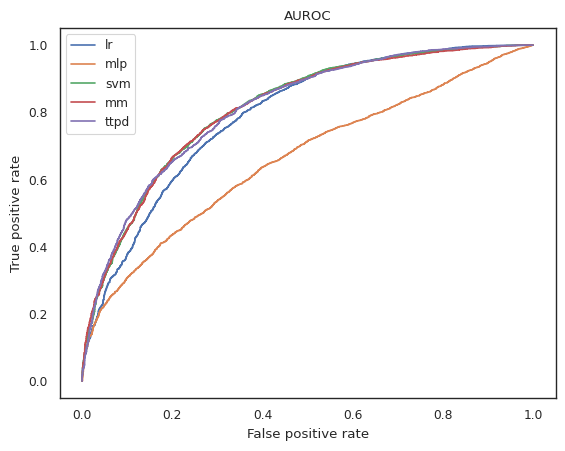

In [7]:
from sklearn.metrics import roc_auc_score, roc_curve
import tabulate
import matplotlib.pyplot as plt
import seaborn
seaborn.set_theme('paper', 'white')


roc_activations = test_activations
roc_labels = test_labels

fprs = {}
tprs = {}
thresholds_roc = {}
aurocs = []
probabilities = {}
for probe_name in probe_names:
    probe = locals()[probe_name]
    probs = probe.predict_proba(roc_activations)
    probabilities[probe_name] = probs
    pos_label_probs = probs[:, 1]
    fpr, tpr, ts = roc_curve(roc_labels, pos_label_probs)
    fprs[probe_name] = fpr
    tprs[probe_name] = tpr
    thresholds_roc[probe_name] = ts
    plt.plot(fpr, tpr, label=probe_name)
    aurocs.append((
        probe_name, roc_auc_score(roc_labels, pos_label_probs),
    ))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("AUROC")

print(tabulate.tabulate(aurocs, headers=("Probe", "AUROC"), floatfmt=".6f"))

Probe       AUPRC
-------  --------
lr       0.770636
mlp      0.685326
svm      0.799329
mm       0.801173
ttpd     0.797891


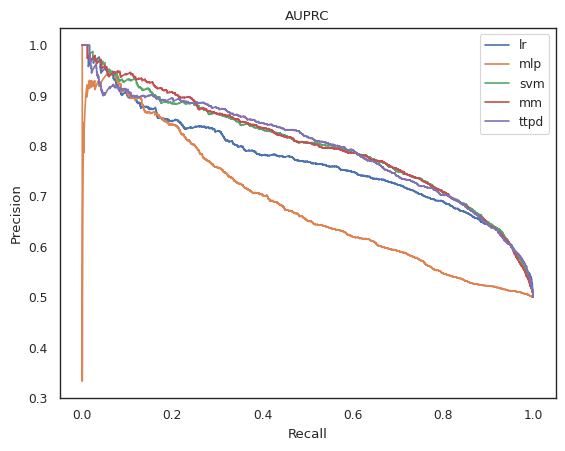

In [8]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn
seaborn.set_theme('paper', 'white')

auprcs = []
precisions = {}
recalls = {}
thresholds_prc = {}
for probe_name in probe_names:
    probe = locals()[probe_name]
    probs = probabilities[probe_name]
    pos_label_probs = probs[:, 1]
    precision, recall, ts = precision_recall_curve(roc_labels, pos_label_probs)
    precisions[probe_name] = precision
    recalls[probe_name] = recall
    thresholds_prc[probe_name] = ts
    plt.plot(recall, precision, label=probe_name)
    auprcs.append((
        probe_name, average_precision_score(roc_labels, pos_label_probs),
    ))
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("AUPRC")

print(tabulate.tabulate(auprcs, headers=("Probe", "AUPRC"), floatfmt=".6f"))

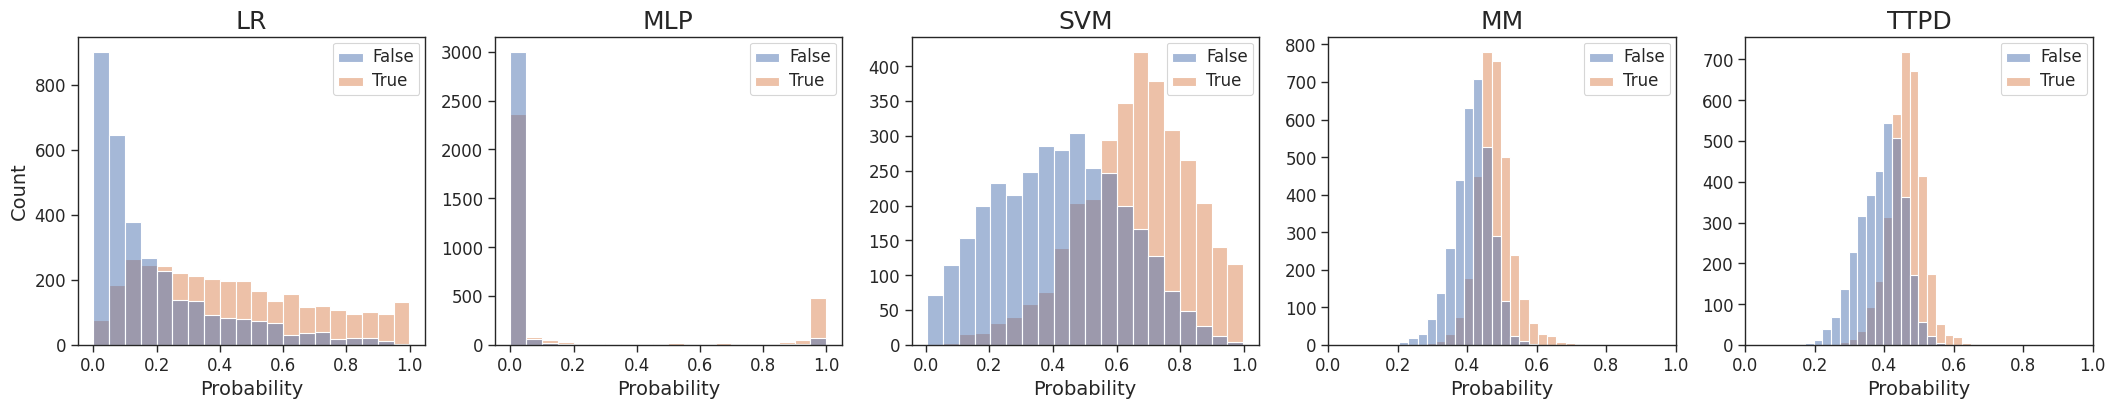

In [13]:
import seaborn
seaborn.set_theme('paper', 'ticks')

def plot_prob_distribution(ax, probs, labels):
    seaborn.histplot({'Probability': probs[:, 1], 'labels': np.array(labels)==1}, x='Probability', hue='labels', ax=ax, bins=20)
    ax.set_xticks(np.linspace(0,1,6))

fig, axes = plt.subplots(1, 5, figsize=(26, 4))
for i, probe_name in enumerate(probe_names):
    probe = locals()[probe_name]
    probs = probabilities[probe_name]
    plot_prob_distribution(axes[i], probs, test_labels)
    axes[i].set_title(probe_name.upper(), fontsize=18)
    axes[i].tick_params(labelsize=12)
    axes[i].set_xlabel(axes[i].get_xlabel(), fontsize=14)
    if i==0:
        axes[i].set_ylabel(axes[i].get_ylabel(), fontsize=14)
    else:
        axes[i].set_ylabel('')
    axes[i].get_legend().set_title('')
    plt.setp(axes[i].get_legend().get_texts(), fontsize=12)

figname = f"figures_distribution/prob_dist_{model_name}.pdf"
if os.path.exists(figname):
    os.remove(figname)
plt.savefig(figname, bbox_inches='tight')


In [443]:
# import matplotlib.pyplot as plt
# seaborn.set_theme('paper', 'white')

# def plot_calibration_gragh(ax, probs_bin, accs_bin):
#     accs_bin = np.array(accs_bin)
#     ax.scatter(probs_bin, accs_bin, alpha=0.5)
#     ax.plot(probs_bin, accs_bin)
#     ax.plot([0,1], [0,1], 'k--')

# fig, axes = plt.subplots(1, 5, figsize=(25, 4))
# eces = []
# for i, probe_name in enumerate(probe_names):
#     probe = locals()[probe_name]
#     probs = probabilities[probe_name]
#     probs_bin, accs_bin = calibration_graph(probs, roc_labels, 10)
#     plot_calibration_gragh(axes[i], probs_bin, accs_bin)
#     axes[i].set_title(probe_name)
#     axes[i].set_xlabel("Probabilities")
#     axes[i].set_ylabel("Frequencies")
#     eces.append((
#         probe_name,
#         calibration_error_expectation(probs_bin, accs_bin),
#         calibration_error_rms(probs_bin, accs_bin),
#         brier_score(probs, roc_labels),
#         aurocs[i][-1],
#         auprcs[i][-1],
#     ))
# print(tabulate.tabulate(eces, headers=("Probe", "ECE", "RMS", "Brier", "AUROC", "AUPRC"), floatfmt='.4f'))


Probe       ECE    RMSCE    Brier    AUROC    AUPRC
-------  ------  -------  -------  -------  -------
lr       0.1900   0.2179   0.2325   0.7916   0.7706
mlp      0.3993   0.4152   0.4025   0.6610   0.6853
svm      0.0625   0.0746   0.1817   0.8125   0.7993
mm       0.1955   0.2194   0.2252   0.8115   0.8012
ttpd     0.1932   0.2186   0.2249   0.8119   0.7979


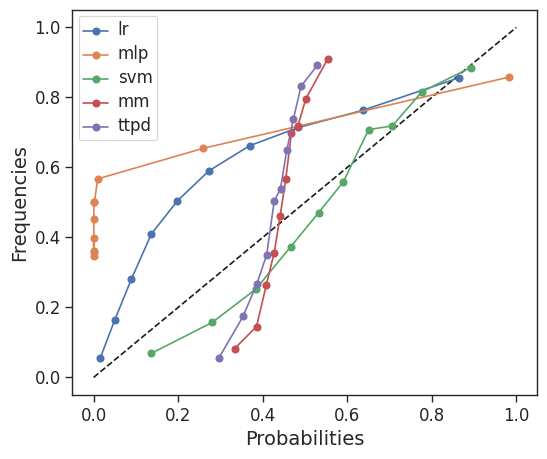

In [24]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

seaborn.set_theme('paper', 'white')

fig, ax = plt.subplots(1,1,figsize=(6,5))
plt.plot([0,1],[0,1],'k--')
res = []
for i, probe_name in enumerate(probe_names):
    probe = locals()[probe_name]
    prob_true, prob_pred = calibration_curve(roc_labels, probabilities[probe_name][:,1], n_bins=10, strategy='quantile')
    plt.plot(prob_pred, prob_true, label=probe_name, marker='o')
    res.append((
        probe_name,
        calibration_error_expectation(prob_true, prob_pred),
        calibration_error_rms(prob_true, prob_pred),
        brier_score_loss(roc_labels, probabilities[probe_name][:,1]),
        aurocs[i][-1],
        auprcs[i][-1],
    ))
plt.legend(loc='best')
plt.ylabel("Frequencies", fontsize=14)
plt.xlabel("Probabilities", fontsize=14)
plt.tick_params(labelsize=12, left=True, bottom=True)
plt.setp(ax.get_legend().get_texts(), fontsize=12)
calibration_chart_dir = f"figures_calibration/{model_name}"
os.makedirs(calibration_chart_dir, exist_ok=True)
plt.savefig(os.path.join(calibration_chart_dir, f"calibration_{test_topic}.pdf"), bbox_inches='tight')

print(tabulate.tabulate(res, headers=("Probe", "ECE", "RMSCE", "Brier", "AUROC", "AUPRC"), floatfmt='.4f'))


In [20]:
p = probabilities['svm'][:,1]
selected_qas = test_labels[p>0.5]
len(selected_qas)/len(test_labels), np.count_nonzero(selected_qas==1) / len(selected_qas)


(0.80255, 0.6405831412373061)

In [ ]:
results = {}
results["train_topics"] = topics
results["test_topic"] = test_topic
results["probes"] = {}
for x, acc in zip(res, test_accs):
    results['probes'][x[0]] = {
        "ECE": x[1],
        "RMSCE": x[2],
        "Brier": x[3],
        'AUROC': x[4],
        'AUPRC': x[5],
        'ACC': acc[-1]
    }

results_dir = "probe_results/"
os.makedirs(results_dir, exist_ok=True)
result_file = os.path.join(results_dir, f"{model_name}.json")
import json
if os.path.exists(result_file):
    with open(result_file, 'r') as fp:
        data = json.load(fp)
else:
    data = []
for i in range(len(data)):
    if set(data[i]['train_topics']) == set(results['train_topics']) and set(data[i]['test_topic']) == set(results['test_topic']):
        data[i] = results
        break
if len(data)==0 or i == len(data)-1:
    data.append(results)
with open(result_file, 'w') as fp:
    json.dump(data, fp)


array([0.9267146 , 0.01880752, 0.00642323, 0.00497383, 0.00333248,
       0.00284617, 0.00231313, 0.00169519, 0.00117644, 0.00106793],
      dtype=float32)

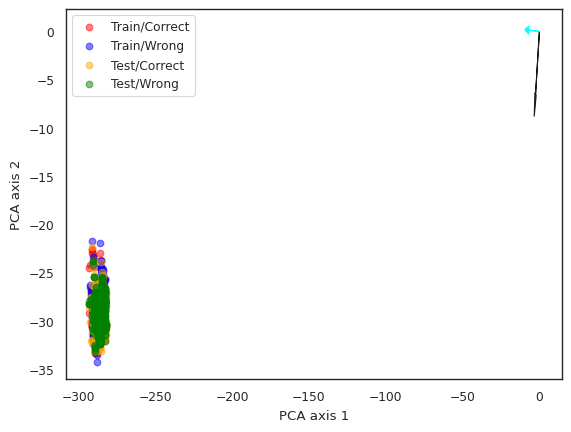

In [51]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca_activations = np.concatenate([train_activations, test_activations])
pca_labels = np.concatenate([train_labels, test_labels])

pca = PCA(n_components=10)
pca.fit(pca_activations)

pca_x_axis_basis, pca_y_axis_basis = 0,1
pca_x_axis = pca.components_[pca_x_axis_basis]
pca_y_axis = pca.components_[pca_y_axis_basis]

train_pos_acts = train_activations[train_labels==1]
train_neg_acts = train_activations[train_labels==0]
test_pos_acts = test_activations[test_labels==1]
test_neg_acts = test_activations[test_labels==0]

train_pos_x = np.sum(pca_x_axis * train_pos_acts, axis=1)
train_pos_y = np.sum(pca_y_axis * train_pos_acts, axis=1)
train_neg_x = np.sum(pca_x_axis * train_neg_acts, axis=1)
train_neg_y = np.sum(pca_y_axis * train_neg_acts, axis=1)

test_pos_x = np.sum(pca_x_axis * test_pos_acts, axis=1)
test_pos_y = np.sum(pca_y_axis * test_pos_acts, axis=1)
test_neg_x = np.sum(pca_x_axis * test_neg_acts, axis=1)
test_neg_y = np.sum(pca_y_axis * test_neg_acts, axis=1)

train_pos_ax = plt.scatter(train_pos_x, train_pos_y, alpha=0.5, c='red')
train_neg_ax = plt.scatter(train_neg_x, train_neg_y, alpha=0.5, c='blue')
test_pos_ax = plt.scatter(test_pos_x, test_pos_y, alpha=0.5, c='orange')
test_neg_ax = plt.scatter(test_neg_x, test_neg_y, alpha=0.5, c='green')

def normalize_direction(x, y, alpha=10):
    norm = np.sqrt(x**2 + y**2)
    return x/norm*alpha, y/norm*alpha

mm_x = np.sum(pca_x_axis * mm.theta_mm)
mm_y = np.sum(pca_y_axis * mm.theta_mm)

norm = np.max([np.max(train_pos_x), np.max(train_neg_x), np.max(test_pos_x), np.max(test_neg_x)]) - np.min([np.min(train_pos_x), np.min(train_neg_x), np.min(test_pos_x), np.min(test_neg_x)])
norm *= 0.6
mm_x, mm_y = normalize_direction(mm_x, mm_y, norm)
mm_arrow_ax = plt.arrow(0,0,mm_x, mm_y, head_width=np.sqrt(norm/10), head_length=3*np.sqrt(norm/10), color='k')

mm_x = np.sum(pca_x_axis * test_mm.theta_mm)
mm_y = np.sum(pca_y_axis * test_mm.theta_mm)
mm_x, mm_y = normalize_direction(mm_x, mm_y, norm)
mm_arrow_ax = plt.arrow(0,0,mm_x, mm_y, head_width=np.sqrt(norm/10), head_length=3*np.sqrt(norm/10), color='cyan')

plt.legend([train_pos_ax, train_neg_ax, test_pos_ax, test_neg_ax],
           ["Train/Correct", "Train/Wrong", "Test/Correct", "Test/Wrong"])
plt.xlabel(f"PCA axis {pca_x_axis_basis}")
plt.ylabel(f"PCA axis {pca_y_axis_basis}")

pca.explained_variance_ratio_


In [91]:
pca_x_axis = pca.components_[0]
pca_y_axis = pca.components_[1]

mm_x = np.sum(pca_x_axis * mm.theta_mm)
mm_y = np.sum(pca_y_axis * mm.theta_mm)
mm_x, mm_y = normalize_direction(mm_x, mm_y)
mm_arrow_ax = plt.arrow(0,0,mm_x, mm_y, head_width=0.5, head_length=1, color='g')

mm_x = np.sum(pca_x_axis * neg_mm.theta_mm)
mm_y = np.sum(pca_y_axis * neg_mm.theta_mm)
mm_x, mm_y = normalize_direction(mm_x, mm_y)
mm_arrow_ax = plt.arrow(0,0,mm_x, mm_y, head_width=0.5, head_length=1, color='r')

mm_x = np.sum(pca_x_axis * conj_mm.theta_mm)
mm_y = np.sum(pca_y_axis * conj_mm.theta_mm)
mm_x, mm_y = normalize_direction(mm_x, mm_y)
mm_arrow_ax = plt.arrow(0,0,mm_x, mm_y, head_width=0.5, head_length=1, color='b')

mm_x = np.sum(pca_x_axis * disj_mm.theta_mm)
mm_y = np.sum(pca_y_axis * disj_mm.theta_mm)
mm_x, mm_y = normalize_direction(mm_x, mm_y)
mm_arrow_ax = plt.arrow(0,0,mm_x, mm_y, head_width=0.5, head_length=1, color='y')


NameError: name 'pca' is not defined

## Batch-run affirmative -> negation generalization

In [ ]:
import numpy as np
import os
import tabulate
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import NuSVC
from sklearn.metrics import roc_auc_score, roc_curve

from probes import *
from utils import *


def run_one_topic(topic, prompt_option, model_name, layer, seed):
    activations = np.concatenate([
        np.load(f"activations_and_labels/{model_name}/{prompt_option}/{topic}/acts_{layer}.npy"),
    ])
    labels = read_csvs([
        f"data/{topic}.csv",
    ])['label']
    labels = np.array(labels.tolist())
    trainset_size = int(len(activations)*0.9)
    train_activations, train_labels = activations[:trainset_size], labels[:trainset_size]
    dev_activations, dev_labels = activations[trainset_size:], labels[trainset_size:]

    test_activations = np.load(f"activations_and_labels/{model_name}/{prompt_option}/neg_{topic}/acts_{layer}.npy")
    test_labels = pd.read_csv(f"data/neg_{topic}.csv")['label']
    test_labels = np.array(test_labels.tolist())

    lr = LogisticRegression(max_iter=10000, random_state=seed)
    lr.fit(train_activations, train_labels)

    mlp = MLPClassifier(hidden_layer_sizes=(512, 128, 64), activation='tanh', random_state=seed)
    mlp.fit(train_activations, train_labels)

    svm = NuSVC(kernel='linear', nu=0.5, probability=True, random_state=seed)
    svm.fit(train_activations, train_labels)

    mm = MMProbe(train_activations, train_labels)

    dev_scaler = StandardScaler()
    dev_scaler.fit(dev_activations)

    dev_accs = []
    probe_names =  ("lr", "mlp", "svm", "mm")
    for name in probe_names:
        probe = locals()[name]
        dev_accs.append([name, accuracy(probe, dev_scaler.transform(dev_activations), dev_labels), accuracy(probe, dev_activations, dev_labels)])
    print(tabulate.tabulate(dev_accs, headers=("Probe", "Centered acc", "Acc")))

    test_scaler = StandardScaler()
    test_scaler.fit(test_activations)

    test_mm = MMProbe(test_activations, test_labels)
    print("Cosine:", cosine_sim(mm.theta_mm, test_mm.theta_mm))

    test_accs = []
    probe_names =  ("lr", "mlp", "svm", "mm")
    for name in probe_names:
        probe = locals()[name]
        test_accs.append([name, accuracy(probe, test_scaler.transform(test_activations), test_labels), accuracy(probe, test_activations, test_labels)])
    print(tabulate.tabulate(test_accs, headers=("Probe", "Centered acc", "Acc"), floatfmt=".6f"))

    roc_activations = test_activations
    # roc_activations = test_scaler.transform(test_activations)
    roc_labels = test_labels

    probes = ('lr', 'mlp', 'svm', 'mm')
    fprs = {}
    tprs = {}
    thresholds = {}
    print("AUROC:")
    aurocs = []
    for probe_name in probes:
        probe = locals()[probe_name]
        pos_label_probs = probe.predict_proba(roc_activations)[:, 1]
        fpr, tpr, ts = roc_curve(roc_labels, pos_label_probs)
        fprs[probe_name] = fpr
        tprs[probe_name] = tpr
        thresholds[probe_name] = ts
        auroc = roc_auc_score(roc_labels, pos_label_probs)
        # auroc = np.count_nonzero((pos_label_probs>0.5)==test_labels)/len(test_labels)
        aurocs.append(auroc)
        print(probe_name, aurocs[-1])
    return {k: v for k, v in zip(probes, aurocs)}


In [3]:
model_names_layer_indices = {
    "Llama-2-7b-hf": 12,
    "Llama-2-7b-chat-hf": 13,
    "Llama-2-13b-hf": 13,
    "Llama-2-13b-chat-hf": 13,
    "Meta-Llama-3.1-8B-hf": 12,
    "Meta-Llama-3.1-8B-Instruct-hf": 13,
    "Meta-Llama-3.1-70B-hf": 33,
    "Meta-Llama-3.1-70B-Instruct-hf": 33,
    "Mistral-Large-Instruct-2407": 37,
}
topics = [
    "animal_class",
    "cities",
    "companies",
    "element_symb",
    "facts",
    "inventors",
    "sp_en_trans",
]
prompt_option = "no_prompt"

seed = 0

aurocs = {p: {} for p in ('lr', 'mlp', 'svm', 'mm')}
for choice in range(4, 5):
    model_name, layer_index = list(model_names_layer_indices.items())[choice]

    print(model_name)
    for k in aurocs:
        aurocs[k][model_name] = {}
    for topic in topics:
        print(f"\n\n===={topic}====")
        auroc = run_one_topic(topic, prompt_option, model_name, layer_index, seed)
        for probe, a in auroc.items():
            aurocs[probe][model_name][topic] = a


Meta-Llama-3.1-8B-hf


====animal_class====
Probe      Centered acc       Acc
-------  --------------  --------
lr             1         1
mlp            1         1
svm            0.941176  0.941176
mm             0.941176  0.941176
Cosine: 0.15270358
Probe      Centered acc       Acc
-------  --------------  --------
lr             0.884146  0.597561
mlp            0.890244  0.530488
svm            0.871951  0.823171
mm             0.670732  0.707317
AUROC:
lr 0.5975609756097561
mlp 0.5304878048780488
svm 0.5853658536585366
mm 0.7073170731707317


====cities====
Probe      Centered acc       Acc
-------  --------------  --------
lr             1         1
mlp            0.993333  1
svm            0.993333  0.98
mm             0.966667  0.906667
Cosine: 0.09486214
Probe      Centered acc       Acc
-------  --------------  --------
lr             0.753342  0.502005
mlp            0.699198  0.500000
svm            0.728610  0.604278
mm             0.761364  0.503342
AUROC:
lr 0.50200534

KeyboardInterrupt: 

In [14]:
for p in ('lr', 'mlp', 'svm', 'mm'):
    x = pd.DataFrame(aurocs[p]).T.loc['Meta-Llama-3.1-70B-Instruct-hf'].tolist()
    print(f"{p}  ", end='')
    for i in x:
        print(f"{i},", end='')
    print()


lr  0.989732142857143,0.9608295919242757,0.47171111111111114,0.7604347323389987,0.8144589338824069,0.8869316359509536,0.5049315330843628,
mlp  0.9925595238095238,0.6541383082158483,0.5969055555555556,0.7946583420048561,0.8630366811561047,0.9190042681272051,0.6309489610265249,
svm  0.9922619047619048,0.9896336755411936,0.5531,0.7704936986934906,0.8628460306566003,0.943108084770434,0.5702384372306809,
mm  0.990922619047619,0.9886167033658383,0.6882111111111111,0.7672563302115851,0.8435903302066652,0.9380258061332742,0.6146381946439401,
